In [2]:
#Description : Installing required libraries
!pip install yfinance
!pip install yahoofinancials
!pip install pandas_datareader

In [3]:
#Description : Importing libraries
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import pandas_datareader as web
import scipy.optimize as sco

In [4]:
#Description : Creating stock symbols
assets=['GOOG', 'NFLX', 'FB', 'AMZN', 'AAPL']

In [5]:
#Description : Getting stock start date
stockStartDate='2020-1-1'

In [6]:
#Description : Getting stock end date
stockEndDate='2022-1-1'

In [ ]:
#Description : Downloading stock data
data=yf.download(assets, start=stockStartDate, end=stockEndDate) 
data.head()

In [9]:
#Description : Creating a dataframe and storing stock closing price
df=pd.DataFrame(data)['Close']
df.head()

,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2020-01-02,75.087502,1898.010010,209.779999,1367.369995,329.809998
2020-01-03,74.357498,1874.969971,208.669998,1360.660034,325.899994
2020-01-06,74.949997,1902.880005,212.600006,1394.209961,335.829987
2020-01-07,74.597504,1906.859985,213.059998,1393.339966,330.750000
2020-01-08,75.797501,1891.969971,215.220001,1404.319946,339.260010


Text(0, 0.5, 'price in $')

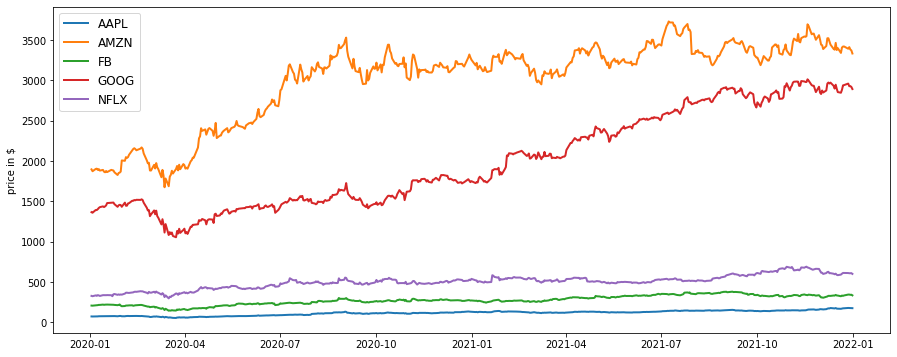

In [10]:
#Description : Visualising stock prices over time
plt.figure(figsize=(15, 6))

for i in df.columns.values:
    plt.plot(df.index, df[i], lw=2, alpha=1,label=i)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

**PORTFOLIO OPTIMISATION FOR LOW RISK-LOW RETURN USING NORMAL VARIANCE AND MONTE CARLO SIMULATION**

Text(0, 0.5, 'daily returns')

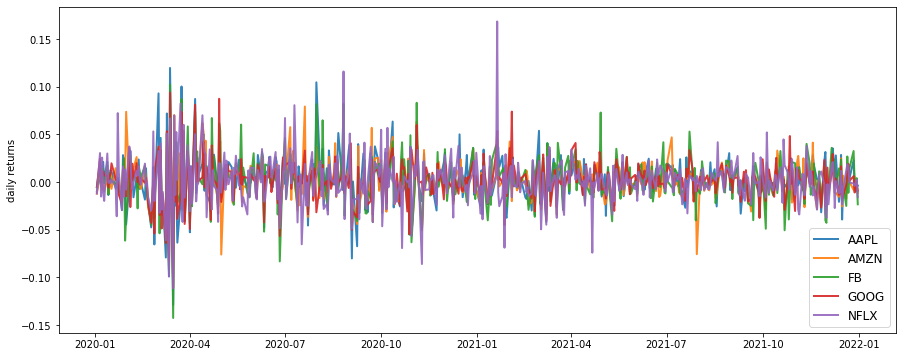

In [11]:
daily_returns = df.pct_change()
plt.figure(figsize=(15, 6))
for i in daily_returns.columns.values:
    plt.plot(daily_returns.index, daily_returns[i], lw=2, alpha=0.9,label=i)
plt.legend(loc='lower right', fontsize=12)
plt.ylabel('daily returns')

In [12]:
def annualised_performance(weights, mean_returns, cov_matrix):
    port_returns = np.sum(mean_returns*weights ) *252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return port_vol, port_returns

In [13]:
#Description : Monte Carlo Simulation Code
def mc_simulated_portfolios(num_port, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_port))
    weights_record = []
    for i in range(num_port):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        port_std_dev, port_return = annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = port_std_dev
        results[1,i] = port_return
        results[2,i] = (port_return - risk_free_rate) / port_std_dev  ### Risk-Adjusted Return
    return results, weights_record

In [14]:
#Description : Enter Risk-Free Rate and Number of Random Porfolio in the Simulation
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()
num_port = int(input('Enter the number of Random Portfolios: '))
risk_free_rate = float(input('Enter the risk-free rate: '))

Enter the number of Random Portfolios: 3000
Enter the risk-free rate: 0


In [15]:
def mc_simulated_efs(mean_returns, cov_matrix, num_port, risk_free_rate):
    results, weights = mc_simulated_portfolios(num_port,mean_returns, cov_matrix, risk_free_rate)
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['Stock_allocation'])
    min_vol_allocation.Stock_allocation = [round(i*100,2)for i in min_vol_allocation.Stock_allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*40)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)


In [16]:
mc_simulated_efs(mean_returns, cov_matrix, num_port, risk_free_rate)

----------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.39
Annualised Volatility: 0.29


                  AAPL   AMZN    FB   GOOG   NFLX
Stock_allocation  0.16  38.03  0.71  50.88  10.22


OUTPUT : This portfolio allocation corresponds to the minimum volatility/risk   


**PORTFOLIO OPTIMISATION FOR HIGH RETURN USING SHARPE RATIO**

In [17]:
pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 2.9 MB/s 
     |████████████████████████████████| 2.8 MB 11.8 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [18]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [19]:
def sharpe_ratio_efs(mean_returns, cov_matrix, num_port, risk_free_rate):
    results, weights = mc_simulated_portfolios(num_port,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['Stock_allocation'])
    max_sharpe_allocation.Stock_allocation = [round(i*100,2)for i in max_sharpe_allocation.Stock_allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    print ("-"*40)
    print ("Maximum Sharpe-Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("Maximum Sharp-Ratio:", round(results[2, max_sharpe_idx],2))
    print ("\n")
    print (max_sharpe_allocation)

In [20]:
sharpe_ratio_efs(mean_returns, cov_matrix, num_port, risk_free_rate)

----------------------------------------
Maximum Sharpe-Ratio Portfolio Allocation

Annualised Return: 0.44
Annualised Volatility: 0.31
Maximum Sharp-Ratio: 1.45


                   AAPL  AMZN    FB   GOOG   NFLX
Stock_allocation  32.86  0.62  2.84  52.36  11.32


OUTCOME : This portfoio allocation corresponds to maximum Sharpe-Ratio.